# Split Dataset into Train, Validation, and Test Subsets for Hyperparameter Tuning and Testing

When training neural networks, it is important to evaluate how well your model generalizes to new, unseen data. If you train and test on the same data, you cannot tell whether the model has truly learned useful patterns or simply memorized the training examples. To address this, data is split into separate subsets: a training set for learning, a validation set for tuning hyperparameters, and a test set for final evaluation. In this notebook, you will learn how to split your data properly, tune hyperparameters like learning rate and hidden layer size using the validation set, and use PyTorch's DataLoader to efficiently batch data during training.

## Setup

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import owncloud
from pathlib import Path
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

### Utility Functions

In [2]:
def train(model: nn.Module, features_train: torch.Tensor, labels_train: torch.Tensor, nepochs:int = 10, learning_rate: float = 0.001) -> None:

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    loss_function = nn.CrossEntropyLoss()

    losses = []
    accuracies = []
    for epoch in tqdm(range(nepochs)):

        optimizer.zero_grad()

        output = model.forward(features_train)

        loss = loss_function(output, labels_train)
        losses.append(loss.item())

        loss.backward()

        optimizer.step()

        accuracy = (labels_train == torch.argmax(output, dim=1)).sum()/len(labels_train)
        accuracies.append(accuracy)

def calculate_accuracy(model: nn.Module, features: torch.Tensor, labels: torch.Tensor) -> torch.Tensor: 

    output = model(features)

    accuracy = (labels == torch.argmax(output, dim=1)).sum()/len(labels)

    return (accuracy*100).item()

def split_data(features: torch.Tensor, labels: torch.Tensor, fractions: list[float] = [0.7, 0.15, 0.15], seed: int = 2026):
    """Split features and labels into train, validation and test subdatasets according to fractions"""

    train_fraction, val_fraction, test_fraction = fractions
    generator = torch.Generator().manual_seed(seed)

    features_train, features_val, features_test = random_split(features, lengths=[train_fraction, val_fraction, test_fraction], generator=generator)
    labels_train, labels_val, labels_test = random_split(labels, lengths=[train_fraction, val_fraction, test_fraction], generator=generator)

    features_train, features_val, features_test = features_train.dataset[features_train.indices].float(), features_val.dataset[features_val.indices].float(), features_test.dataset[features_test.indices].float()
    labels_train, labels_val, labels_test = labels_train.dataset[labels_train.indices], labels_val.dataset[labels_val.indices], labels_test.dataset[labels_test.indices]

    return features_train, features_val, features_test, labels_train, labels_val, labels_test

def create_model(n_cells: int = 1268, num_classes: int = 3, hidden_layer_size: int = 64) -> nn.Module:
    """Create a neural network model."""
    torch.manual_seed(2026)
    model = nn.Sequential(
        nn.Linear(n_cells, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, num_classes)
    )
    return model

def train_with_early_stopping(model: nn.Module, features_train: torch.Tensor, labels_train: torch.Tensor,
                               features_val: torch.Tensor, labels_val: torch.Tensor,
                               patience: int = 10, max_epochs: int = 300, learning_rate: float = 0.001) -> int:
    """
    Train a model with early stopping based on validation accuracy.

    Returns the epoch at which training stopped.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    best_acc = 0.0
    wait = 0
    stopped_epoch = max_epochs

    for epoch in range(max_epochs):
        # Training step
        optimizer.zero_grad()
        output = model.forward(features_train)
        loss = loss_function(output, labels_train)
        loss.backward()
        optimizer.step()

        # Calculate validation accuracy
        val_output = model(features_val)
        val_acc = (labels_val == torch.argmax(val_output, dim=1)).sum()/len(labels_val)
        val_acc = (val_acc * 100).item()

        # Early stopping logic
        if val_acc > best_acc:
            best_acc = val_acc
            wait = 0
        else:
            wait += 1

        if wait > patience:
            stopped_epoch = epoch
            break

    return stopped_epoch


class utils:
    train = train
    calculate_accuracy = calculate_accuracy
    split_data = split_data
    create_model = create_model
    train_with_early_stopping = train_with_early_stopping

### Download Data

In [3]:
Path('data').mkdir(exist_ok=True, parents=True)

owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/QdABQ7tHCfM52CH').get_file('/', f'data/spike_count_and_stimulus_type_per_trial.pt')

True

In [4]:
data = torch.load('data/spike_count_and_stimulus_type_per_trial.pt')

features = data['features']
labels = data['labels']

## Section 1: Split Data into Train, Validation, and Test Data.

Splitting your data into separate subsets is done to evaluate how well the model generalizes to unseen data. You should use a training set to fit the model's parameters and a separate validation set to tune hyperparameters and make decisions about model architecture. The test set will not be used at all during training and is only used to evaluate the final model after tuning hyperparameters, choosing a model architecture, and training the model performance. In this section, you will practice using PyTorch's `random_split` function to divide your dataset into these subsets according to specified fractions.

| Code | Description |
| :-- | :-- |
| `train_fraction = 0.7` | Set the fraction of data for training to 70%. |
| `val_fraction = 0.15` | Set the fraction of data for validation to 15%. |
| `test_fraction = 1 - train_fraction - val_fraction` | Calculate test fraction as the remainder. |
| `subset_train, subset_val, subset_test = random_split(subset, lengths = [fraction_train, fraction_val, fraction_test])` | Splits the data into subsets. The fractions in `lengths` specifies the proportion of the data that should go into each subset. |
| `generator = torch.Generator().manual_seed(some_num)` | Sets the seed for generating random numbers. |
| `subset_train, subset_val, subset_test = random_split(features, lengths = [fraction_train, fraction_val, fraction_test], generator=generator)` | The parameter `generator` can be fixed to make sure that the data is split in exactly the same way each time. This ensures reproducibility. |

#### **Exercises**

**Example**: Split the dataset into only two subsets: a train and a test subset. Set the fraction of the data going into the train dataset to 0.8 and the fraction going into test subset to 0.2. Assign the subsets to variables named `features_train` and `features_test`, respectively, and run the cell that makes a bar plot of the number of samples in each subset.

In [5]:
train_fraction = 0.8
test_fraction = 0.2

features_train, features_test = random_split(features, lengths=[train_fraction, test_fraction])

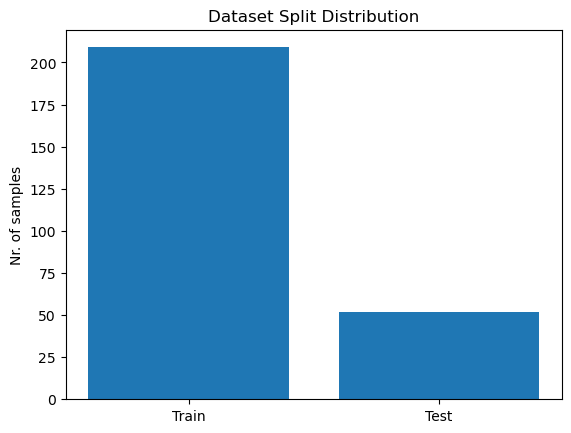

In [6]:
plt.bar(['Train', 'Test'], [len(features_train), len(features_test)])
plt.ylabel("Nr. of samples")
plt.title('Dataset Split Distribution');

**Exercise**: Split the features tensor into three subsets according to the fractions provided below. One subset is used for training the model, one for validation during training - i.e. to train hyperparameters, and the last subset is used to test the final model. Assign the subsets to variables named `features_train`, `features_val`, and `features_test`, respectively.

In [7]:
train_fraction = 0.7
val_fraction = 0.15
test_fraction = 1-train_fraction-val_fraction

Text(0.5, 1.0, 'Dataset Split Distribution')

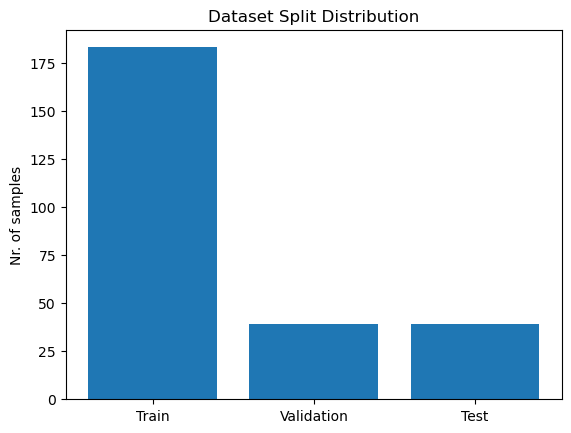

In [9]:
plt.bar(['Train', 'Validation', 'Test'], [len(features_train), len(features_val), len(features_test)])
plt.ylabel("Nr. of samples")
plt.title('Dataset Split Distribution')

**Exercise**: Set the fraction of the data going into the train dataset to `0.8` and the fractions going into the validation and test subsets to `0.1`. Then, split the features tensor again and run the cell plotting the number of samples in each subdataset.

Text(0.5, 1.0, 'Dataset Split Distribution')

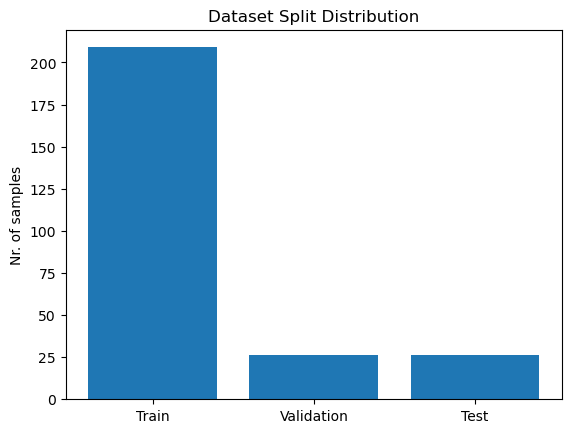

In [11]:
plt.bar(['Train', 'Validation', 'Test'], [len(features_train), len(features_val), len(features_test)])
plt.ylabel("Nr. of samples")
plt.title('Dataset Split Distribution')

**Exercise**: Split the **labels** tensor into three subsets according to the fractions provided below. One subset is used for training the model, one for validation during training - i.e. to tune hyperparameters, and the last subset is used to test the final model. Assign the subsets to variables named `labels_train`, `labels_val`, and `labels_test`, respectively.

In [12]:
train_fraction = 0.8
val_fraction = 0.1
test_fraction = 1-train_fraction-val_fraction

Text(0.5, 1.0, 'Labels Split Distribution')

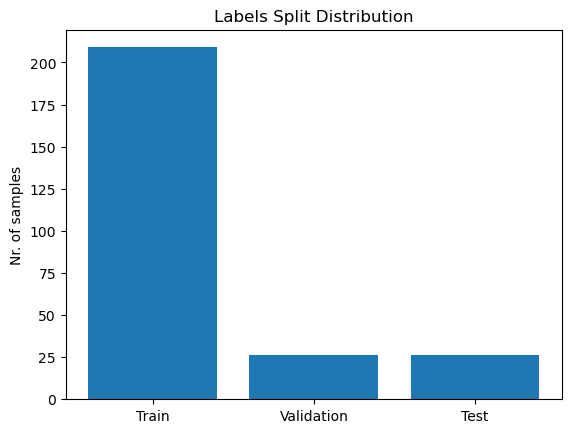

In [14]:
plt.bar(['Train', 'Validation', 'Test'], [len(labels_train), len(labels_val), len(labels_test)])
plt.ylabel("Nr. of samples")
plt.title('Labels Split Distribution')

As the name suggests, the `random_split` function splits the data randomly each time it's run. This means that even though the proportions are the same, you'll have different samples in the train, validation, and test subsets each time you run the code to split the data. To ensure reproducibility - that you get the same result each time you train the model on your data, you have to provide a random number generator with a fixed seed to the function.

**Exercise**: In the cell below, the data is split without providing a generator. Run the cell repeatedly. When the first feature and label is displayed, do you get the same or different values when you run the code each time?

In [15]:
train_fraction = 0.7
val_fraction = 0.15
test_fraction = 1-train_fraction-val_fraction

features_train, features_val, features_test = random_split(features, lengths=[train_fraction, val_fraction, test_fraction])
labels_train, labels_val, labels_test = random_split(labels, lengths=[train_fraction, val_fraction, test_fraction])

features_train[0], labels_train[0]

(tensor([ 1., 13., 16.,  ...,  6.,  0.,  0.]), tensor(2))

**Exercise**: Create a PyTorch Pseudorandom Number Generator from the seed below.

**Hint**: See code reference table.

In [16]:
seed = 1

**Exercise**: Create a PyTorch Generator from the seed below. Then, run the cell below where the data is split with the generator passed to the `random_split` function. Do you get the same or different values for the features when you run the code repeatedly?

In [18]:
seed = 2026

In [19]:
generator = ___ # UPDATE ME

train_fraction = 0.7
val_fraction = 0.15
test_fraction = 1-train_fraction-val_fraction

features_train, features_val, features_test = random_split(features, lengths=[train_fraction, val_fraction, test_fraction], generator=generator)
labels_train, labels_val, labels_test = random_split(labels, lengths=[train_fraction, val_fraction, test_fraction], generator=generator)

features_train[0]

TypeError: randperm() received an invalid combination of arguments - got (int, generator=Text), but expected one of:
 * (int n, *, torch.Generator generator, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (int n, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


## Section 2: Tune Hyperparameters on Validation Dataset

Hyperparameters are settings that you choose before training begins, such as the learning rate, number of epochs, or the size of hidden layers. Unlike model parameters (weights and biases), hyperparameters are not learned from the data. Finding the right hyperparameters can significantly improve model performance. The validation set allows you to compare different hyperparameter choices without contaminating your test set, which should only be used for final evaluation.

| Code | Description |
| :-- | :-- |
| `for hyperparam_value in hyperparam_values:` | Loops through each hyperparameter value to train the network with. |
| `model = utils.create_model(hidden_layer_size=hidden_layer_size)` | Creates a new model instance with the specified hidden layer size. |
| `utils.train(model, features_train, labels_train)` | Trains the model on the training data. |
| `utils.train(model, features_train, labels_train, learning_rate=learning_rate)` | Trains the model with a specific learning rate. |
| `utils.train_with_early_stopping(model, features_train, labels_train, features_val, labels_val, patience=patience)` | Trains the model with early stopping, monitoring validation accuracy. |
| `utils.calculate_accuracy(model, features, labels)` | Calculates the model's accuracy. |
| `accuracies_val.append(accuracy_val)` | Adds the accuracy value to a list for later comparison. |

#### **Exercises**

Run the cell below to split the features and labels into train, validation, and test subsets.

In [21]:
SEED = 2026
generator = torch.Generator().manual_seed(SEED)

train_fraction = 0.6
val_fraction = 0.2
test_fraction = 1-train_fraction-val_fraction

features_train, features_val, features_test = random_split(features, lengths=[train_fraction, val_fraction, test_fraction], generator=generator)
labels_train, labels_val, labels_test = random_split(labels, lengths=[train_fraction, val_fraction, test_fraction], generator=generator)

features_train, features_val, features_test = features_train.dataset[features_train.indices].float(), features_val.dataset[features_val.indices].float(), features_test.dataset[features_test.indices].float()
labels_train, labels_val, labels_test = labels_train.dataset[labels_train.indices], labels_val.dataset[labels_val.indices], labels_test.dataset[labels_test.indices]

**Example**: Fill the blank lines below to create a list containing the following hidden layer sizes: 4, 8, 16, 32, 64, 128, 256. Then run the code to create a new model for each hidden layer size, train the model, and evaluate the trained model's accuracy on the validation dataset. Which hidden layer size produces the best result?

100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


(0.0, 101.0)

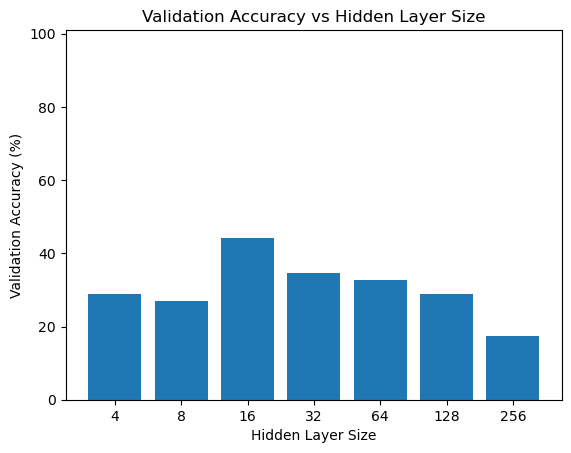

In [22]:
# set hidden layer sizes
hidden_layer_sizes = ___ # complete this line
hidden_layer_sizes = [4, 8, 16, 32, 64, 128, 256,] # solution

accuracies_val = []
for hidden_layer_size in hidden_layer_sizes:
    # create model
    model = utils.create_model(hidden_layer_size=hidden_layer_size,)

    # train the model
    utils.train(model, features_train, labels_train,)

    # Calculate validation accuracy
    accuracy_val = utils.calculate_accuracy(model, features_val, labels_val)
    accuracies_val.append(accuracy_val)

# plot results
plt.bar([str(h) for h in hidden_layer_sizes], accuracies_val)
plt.xlabel('Hidden Layer Size')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy vs Hidden Layer Size')
plt.ylim([0, 101])

The model below is created with `16` neurons in the hidden layer.

**Exercise**: Fill the blank line below with a list containing the following learning rates: 0.01, 0.001, 0.0001, 0.00001. Then, run the code to create a new model for each learning rate, train the model, and evaluate the trained model's accuracy on the validation dataset. Which learning rate produces the best result? Do multiple learning rates produce the same result?

100%|██████████| 10/10 [00:00<00:00, 150.22it/s]


(0.0, 101.0)

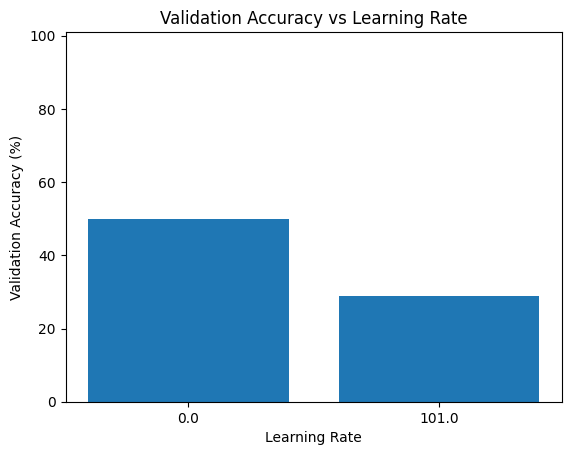

In [ ]:
# set learning rates to try out
learning_rates = __ # UPDATE ME

accuracies_val = []
for learning_rate in learning_rates:
    # create model
    torch.manual_seed(SEED)
    model = utils.create_model(hidden_layer_size=16)

    # train the model
    utils.train(model, features_train, labels_train, learning_rate=learning_rate)

    # calculate validation accuracy
    accuracy_val = utils.calculate_accuracy(model, features_val, labels_val)
    accuracies_val.append(accuracy_val)

# plot results
plt.bar([str(lr) for lr in learning_rates], accuracies_val)
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy vs Learning Rate')
plt.ylim([0, 101])

Another important hyperparameter is `patience` in early stopping. Early stopping monitors the model's performance on the validation set during training and stops when performance stops improving. The `patience` parameter controls how many epochs to wait for improvement before stopping.

**Exercise**: Fill the blank line below with a list containing the following patience values: 2, 5, 10, 20. Then, run the code to create a new model for each patience value, train the model with early stopping, and evaluate the trained model's accuracy on the validation dataset. The utility function `utils.train_with_early_stopping` takes `patience` as a parameter. Which patience value produces the best result? Does a larger patience always lead to better accuracy?

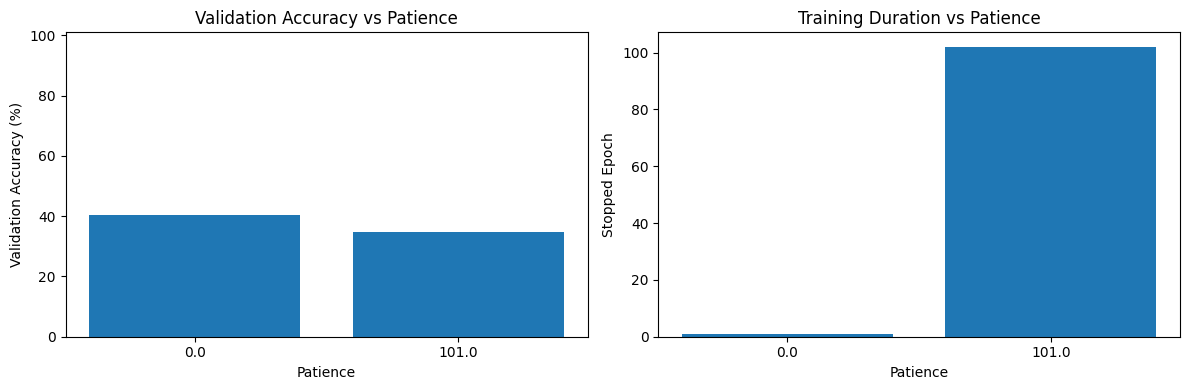

In [ ]:
# set patience values to try out
patience_values = ___ # UPDATE ME

accuracies_val = []
stopped_epochs = []
for patience in patience_values:
    # create model
    torch.manual_seed(SEED)
    model = utils.create_model(hidden_layer_size=16)

    # train the model with early stopping
    stopped_epoch = utils.train_with_early_stopping(
        model, features_train, labels_train, 
        features_val, labels_val,
        patience=patience, learning_rate=0.0001
    )
    stopped_epochs.append(stopped_epoch)

    # calculate validation accuracy
    accuracy_val = utils.calculate_accuracy(model, features_val, labels_val)
    accuracies_val.append(accuracy_val)

# plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar([str(p) for p in patience_values], accuracies_val)
axes[0].set_xlabel('Patience')
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].set_title('Validation Accuracy vs Patience')
axes[0].set_ylim([0, 101])

axes[1].bar([str(p) for p in patience_values], stopped_epochs)
axes[1].set_xlabel('Patience')
axes[1].set_ylabel('Stopped Epoch')
axes[1].set_title('Training Duration vs Patience')

plt.tight_layout()

**Demo**: In practice, the optimal value of one hyperparameter will depend on another hyperparameter. Therefore, you often want to tune multiple hyperparameters simultaneously. A **grid search** systematically tries all combinations of hyperparameter values. Below, we perform a grid search over hidden layer size, learning rate, and early stopping patience to find the best combination.

In [26]:
# define hyperparameter search space
hidden_layer_sizes = [8, 16, 32, 64]
learning_rates = [0.01, 0.001, 0.0001]
patience_values = [2, 5, 20]

# track best results
best_accuracy = 0.0
best_hyperparams = {}

# grid search: try all combinations
total_combinations = len(hidden_layer_sizes) * len(learning_rates) * len(patience_values)
print(f"Testing {total_combinations} hyperparameter combinations...\n")

for hidden_layer_size in hidden_layer_sizes:
    for learning_rate in learning_rates:
        for patience in patience_values:
            # create model
            torch.manual_seed(SEED)
            model = utils.create_model(hidden_layer_size=hidden_layer_size)

            # train the model with early stopping
            utils.train_with_early_stopping(
                model, features_train, labels_train,
                features_val, labels_val,
                patience=patience, learning_rate=learning_rate
            )

            # calculate validation accuracy
            accuracy_val = utils.calculate_accuracy(model, features_val, labels_val)

            # check if this is the best so far
            if accuracy_val > best_accuracy:
                best_accuracy = accuracy_val
                best_hyperparams = {
                    'hidden_layer_size': hidden_layer_size,
                    'learning_rate': learning_rate,
                    'patience': patience
                }

# print results
print(f"\nBest validation accuracy: {best_accuracy:.1f}%")
print(f"Best hyperparameters:")
print(f"  - Hidden layer size: {best_hyperparams['hidden_layer_size']}")
print(f"  - Learning rate: {best_hyperparams['learning_rate']}")
print(f"  - Patience: {best_hyperparams['patience']}")

Testing 36 hyperparameter combinations...


Best validation accuracy: 51.9%
Best hyperparameters:
  - Hidden layer size: 32
  - Learning rate: 0.0001
  - Patience: 5


**Exercise**: Now that we have found the optimal hyperparameters, we can check how well the model generalizes. That's done by evaluating it on the **test data**, which it hasn't seen yet. Fill in the blank lines in the code below to create the final model with the `best_hidden_size`, train it with early stopping using `learning_rate = best_learning_rate` and `patience = best_patience`, and test it with the `features_test` and `labels_test` subsets.

In [ ]:
# use best hyperparameters found from tuning
best_hidden_size = best_hyperparams['hidden_layer_size']
best_learning_rate = best_hyperparams['learning_rate']
best_patience = best_hyperparams['patience']

# create final model
torch.manual_seed(SEED)
final_model = utils.create_model(___) # UPDATE ME fill in blank with hidden layer size

utils.train_with_early_stopping(final_model, 
                                features_train, 
                                labels_train, 
                                features_val, 
                                labels_val,
                                patience=___, 
                                learning_rate=___) # UPDATE ME: fill in blanks with the best hyperparameters

# evaluate final model on test data
test_accuracy = utils.calculate_accuracy(final_model, ___, ___) # UPDATE ME: fill in blanks with the features and labels from the test subset
print(f'\nFinal Test Accuracy: {test_accuracy:.1f}%')

## Section 3: Do the Fractions Matter in the Train, Validation, Test Split?

The way you split your data between training, validation, and test sets can also affect model performance. A larger training set gives the model more examples to learn from, which generally improves accuracy. However, if the validation or test sets are too small, your performance estimates become unreliable because they are based on too few samples. Finding the right balance depends on your total dataset size. With limited data, you may need to allocate more to training.

| Code | Description |
| :-- | :-- |
|`subset_train, subset_val, subset_test = utils.split_data(features, labels, fractions = [train_fraction, val_fraction, test_fraction])` | Utility function that takes care of splitting features and labels into subsets and convert the subsets into correct format for training. |
| `len(features_train)` | Get the number of samples in the training set. |

#### **Exercises**

Run the cell below to define the model used in this section. We will use the best hyperparameters found in Section 2.

In [28]:
# use best hyperparameters found from tuning
best_hidden_size = best_hyperparams['hidden_layer_size']
best_learning_rate = best_hyperparams['learning_rate']
best_patience = best_hyperparams['patience']

**Example**: Train a model using a 50/25/25 split (50% train, 25% validation, 25% test) and evaluate test accuracy.

In [29]:
# 50/25/25 split
train_fraction = 0.5
val_fraction = 0.25
test_fraction = 1 - train_fraction - val_fraction

In [30]:
features_train, features_val, features_test, labels_train, labels_val, labels_test = utils.split_data(features, labels, fractions=[train_fraction, val_fraction, test_fraction])

print(f"Train samples: {len(features_train)}, Validation samples: {len(features_val)}, Test samples: {len(features_test)}")

# train and evaluate
torch.manual_seed(SEED)
model = utils.create_model(hidden_layer_size=best_hidden_size)
utils.train_with_early_stopping(model, 
                                features_train, 
                                labels_train, 
                                features_val, 
                                labels_val, 
                                patience=best_patience, 
                                learning_rate=best_learning_rate)

accuracy = utils.calculate_accuracy(model, features_test, labels_test)
print(f"Test accuracy with 50/25/25 split: {accuracy:.1f}%")

Train samples: 131, Validation samples: 65, Test samples: 65
Test accuracy with 50/25/25 split: 36.9%


**Exercise**: Set the fractions for a 33/33/33 split (33% train, 33% validation, 33% test) and run the cell where the model is trained and evaluated. How does the test accuracy compare to the 50/25/25 split? Why might allocating less data to training affect the result?

In [32]:
features_train, features_val, features_test, labels_train, labels_val, labels_test = utils.split_data(features, labels, fractions=[train_fraction, val_fraction, test_fraction])

print(f"Train samples: {len(features_train)}, Validation samples: {len(features_val)}, Test samples: {len(features_test)}")

# train and evaluate
torch.manual_seed(SEED)
model = utils.create_model(hidden_layer_size=best_hidden_size)
utils.train_with_early_stopping(model, 
                                features_train, 
                                labels_train, 
                                features_val, 
                                labels_val, 
                                patience=best_patience, 
                                learning_rate=best_learning_rate)

accuracy = utils.calculate_accuracy(model, features_test, labels_test)
print(f"Test accuracy with 33/33/33 split: {accuracy:.1f}%")

Train samples: 87, Validation samples: 86, Test samples: 88
Test accuracy with 33/33/33 split: 42.0%


**Exercise**: Set the fractions for a 90/5/5 split (90% train, 5% validation, 5% test) and run the cell where the model is trained and evaluated. How does the test accuracy compare to the 50/25/25 split?

In [34]:
features_train, features_val, features_test, labels_train, labels_val, labels_test = utils.split_data(features, labels, fractions=[train_fraction, val_fraction, test_fraction])

print(f"Train samples: {len(features_train)}, Validation samples: {len(features_val)}, Test samples: {len(features_test)}")

# train and evaluate
torch.manual_seed(SEED)
model = utils.create_model(hidden_layer_size=best_hidden_size)
utils.train_with_early_stopping(model, 
                                features_train, 
                                labels_train, 
                                features_val, 
                                labels_val, 
                                patience=best_patience, 
                                learning_rate=best_learning_rate)

accuracy = utils.calculate_accuracy(model, features_test, labels_test)
print(f"Test accuracy with 90/5/5 split: {accuracy:.1f}%")

Train samples: 235, Validation samples: 13, Test samples: 13
Test accuracy with 90/5/5 split: 53.8%


Typical splits to use are 70/15/15, 60/20/20, 80/10/10, since these give a reasonable balance between having enough samples for the training in the train subset and enough samples in the validation and test subsets for reliable evaluation of the trained model. However, it depends on how much data you have. If you have millions of samples, then 1 % may still provide you with enough samples for the validation and test subsets.

## Section 4: Batching Data to Train Efficiently

When training neural networks, you can process all your data at once (full-batch gradient descent), one sample at a time (stochastic gradient descent), or in small groups called mini-batches. Full-batch provides stable and precise convergence, but can be slow for large datasets. Stochastic gradient descent is faster and can escape local minima, but is more noisy. Mini-batch gradient descent offers a balance between these two extremes. It provides more stable gradient estimates than pure stochastic gradient descent while still enabling relatively frequent updates of the weights. PyTorch's DataLoader class handles batching automatically, and also provides other useful features like shuffling the data between epochs to prevent the model from learning patterns based on the order of samples.

| Code | Description |
|---|---|
| `DataLoader(dataset)` | Create a DataLoader for `dataset` and assign it to the variable `dataloader`. |
| `DataLoader(dataset, batch_size = some_num)` | Create a DataLoader for `dataset` where the size of each batch set to `some_num` (default batchsize is 1). |
| `DataLoader(dataset, batch_size = some_num, drop_last = True)` | Create a DataLoader for `dataset` and drop last batch if it's not the same size as the other batches. |
| `DataLoader(dataset, shuffle = True)` | Create a DataLoader for `dataset` and reshuffle the data at each iteration (epoch) during training. |
| `dataloader = DataLoader(dataset)` | Create a DataLoader for `dataset` and assign it to the variable `dataloader`. |

#### **Exercises**

In [35]:
dataset = TensorDataset(features, labels)

**Example**: Create a dataloader using the TensorDataset variable `dataset` created above. Then run the cell below where the dataloader is looped through and the dimensions of the features in each batch are printed. How many samples are in each batch?

In [ ]:
dataloader = DataLoader(dataset)

In [37]:
n_samples_processed = 0
for idx_batch, (features_batch, labels_batch) in enumerate(dataloader):
    print(f"Batch nr: {idx_batch}, number of samples in batch: {features_batch.shape[0]}, total number of samples looped through: {n_samples_processed}")

    n_samples_processed += features_batch.shape[0]

    if idx_batch > 4:
        break

Batch nr: 0, number of samples in batch: 1, total number of samples looped through: 0
Batch nr: 1, number of samples in batch: 1, total number of samples looped through: 1
Batch nr: 2, number of samples in batch: 1, total number of samples looped through: 2
Batch nr: 3, number of samples in batch: 1, total number of samples looped through: 3
Batch nr: 4, number of samples in batch: 1, total number of samples looped through: 4
Batch nr: 5, number of samples in batch: 1, total number of samples looped through: 5


By default, the batch size in the dataloader is `1`.

**Exercise**: Create a dataloader with batch size `8`. Then, run the cell below with the loop going through the batches.

In [39]:
n_samples_processed = 0
for idx_batch, (features_batch, labels_batch) in enumerate(dataloader):
    print(f"Batch nr: {idx_batch}, number of samples in batch: {features_batch.shape[0]}, total number of samples looped through: {n_samples_processed}")

    n_samples_processed += features_batch.shape[0]

    if idx_batch > 5:
        break

Batch nr: 0, number of samples in batch: 8, total number of samples looped through: 0
Batch nr: 1, number of samples in batch: 8, total number of samples looped through: 8
Batch nr: 2, number of samples in batch: 8, total number of samples looped through: 16
Batch nr: 3, number of samples in batch: 8, total number of samples looped through: 24
Batch nr: 4, number of samples in batch: 8, total number of samples looped through: 32
Batch nr: 5, number of samples in batch: 8, total number of samples looped through: 40
Batch nr: 6, number of samples in batch: 8, total number of samples looped through: 48


**Exercise**: Create a dataloader with batch size `50` and run the cell with the loop.

In [41]:
n_samples_processed = 0
for idx_batch, (features_batch, labels_batch) in enumerate(dataloader):
    print(f"Batch nr: {idx_batch}, number of samples in batch: {features_batch.shape[0]}, total number of samples looped through: {n_samples_processed}")

    n_samples_processed += features_batch.shape[0]

    if idx_batch > 5:
        break

Batch nr: 0, number of samples in batch: 50, total number of samples looped through: 0
Batch nr: 1, number of samples in batch: 50, total number of samples looped through: 50
Batch nr: 2, number of samples in batch: 50, total number of samples looped through: 100
Batch nr: 3, number of samples in batch: 50, total number of samples looped through: 150
Batch nr: 4, number of samples in batch: 50, total number of samples looped through: 200
Batch nr: 5, number of samples in batch: 11, total number of samples looped through: 250


The last batch in this dataset has fewer samples than the batch size when the batch size is set to 50. That's because the total number of samples in the dataset is not evenly divisible by 50. There aren't enough samples left to fill up a batch of size 50 in the last iteration.

**Exercise**: Create the dataloader with a batch size of 50 again, but set `drop_last=True`. What happens to the last batch in the loop?

In [43]:
n_samples_processed = 0
for idx_batch, (features_batch, labels_batch) in enumerate(dataloader):
    print(f"Batch nr: {idx_batch}, number of samples in batch: {features_batch.shape[0]}, total number of samples looped through: {n_samples_processed}")

    n_samples_processed += features_batch.shape[0]

    if idx_batch > 5:
        break

Batch nr: 0, number of samples in batch: 50, total number of samples looped through: 0
Batch nr: 1, number of samples in batch: 50, total number of samples looped through: 50
Batch nr: 2, number of samples in batch: 50, total number of samples looped through: 100
Batch nr: 3, number of samples in batch: 50, total number of samples looped through: 150
Batch nr: 4, number of samples in batch: 50, total number of samples looped through: 200


If the last batch is smaller than the others, it's dropped when `drop_last` is set to `True`. A useful feature of PyTorch's `DataLoader` is that you don't have to add extra code to handle special cases like this yourself when you loop through the batches, the `DataLoader` does it for you. It can also take care of other things like shuffling your data.

**Exercise**: Run the cell below where a dataloader is created with the default batch size and without shuffling. Do you get the same output when you run the cell again?

You should get the same feature values and label in the previous exercise no matter how many times you reran the code cell.

**Exercise**: Create a dataloader for the dataset again, but this time, set the parameter `shuffle = True`. Then run the cell below that gets a set of features and their label from the dataset. Do you get the same values when you run it repeatedly now?

In [46]:
feature, label = next(iter(dataloader))
feature, label

(tensor([[ 0., 22., 10.,  ...,  2.,  0.,  0.]]), tensor([2]))